<a href="https://colab.research.google.com/github/balakrishnanvinchu/fair_accountable_machine_learning/blob/main/Group_16_Assignment_2_FATML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Credit Card Approval Prediction using MLP with LIME and SHAP Explanations

 ## Task 1: Load the dataset and perform exploratory data analysis via appropriate visualization. Normalize the features as appropriate

In [3]:
%pip install lime shap

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import lime
import lime.lime_tabular
import shap
from sklearn.utils import resample
import random
from IPython.display import display
import IPython

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [5]:
# Load the dataset
data = pd.read_csv('UniversalBank.csv')

# Display basic information
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
display(data.head())

Dataset shape: (5000, 14)

First 5 rows:


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [6]:
# Basic statistics
print("\nDescriptive statistics:")
display(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Descriptive statistics:


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000



Missing values:
ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


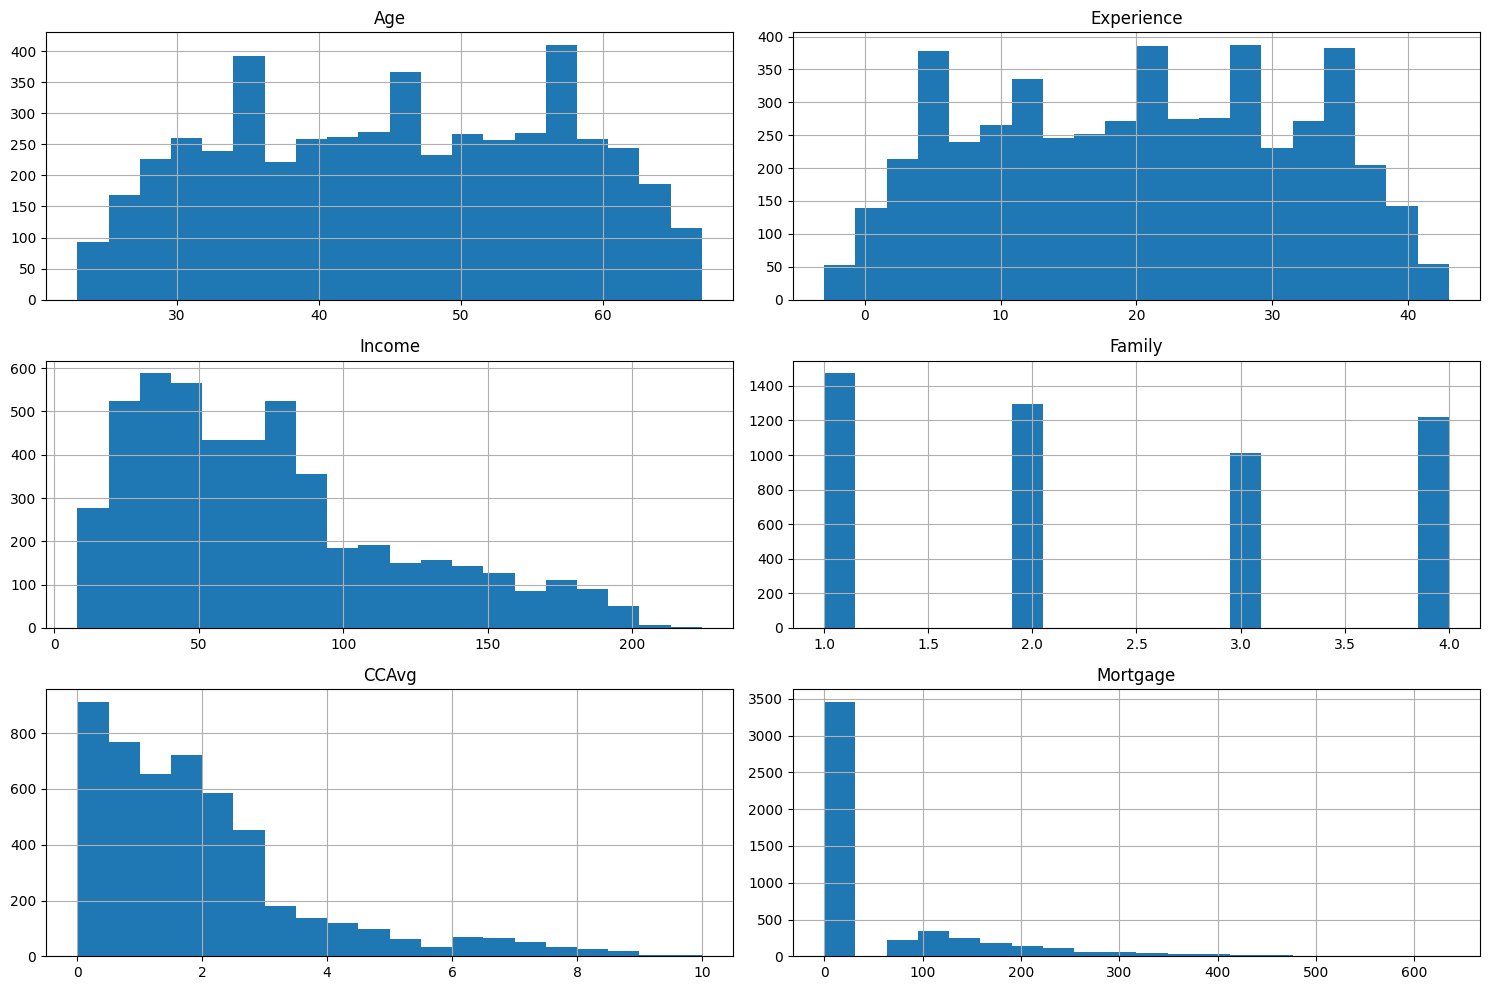

In [7]:
# Visualize the distribution of numerical features
numerical_cols = ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']
data[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

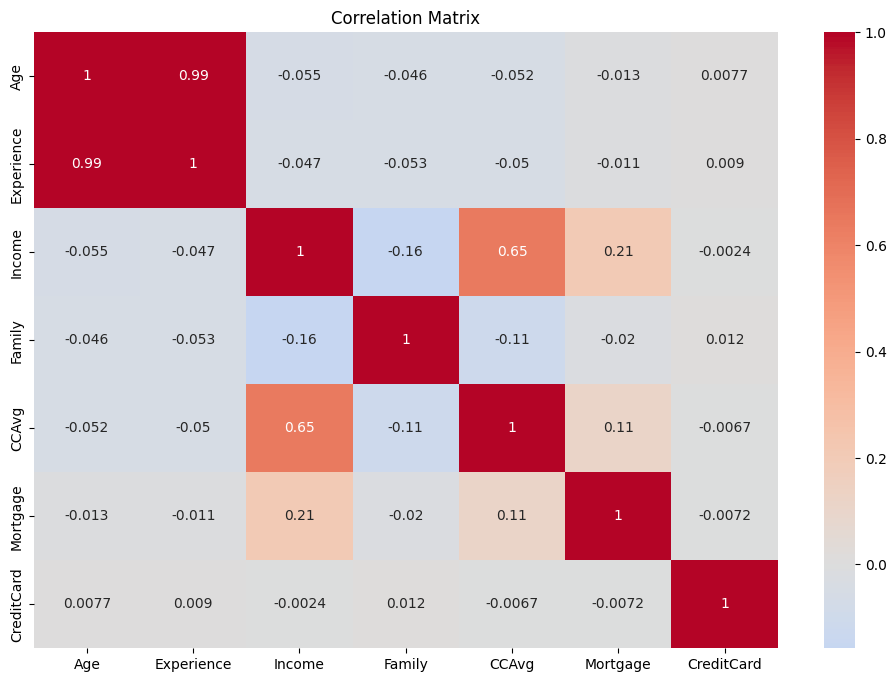

In [8]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data[numerical_cols + ['CreditCard']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Prepare data for modeling
# Drop ID and ZIP Code as they are not useful for prediction
data = data.drop(['ID', 'ZIP Code'], axis=1)

# Split into features and target
X = data.drop('CreditCard', axis=1)
y = data['CreditCard']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets (we'll use the entire data for cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4000, 11)
Test set shape: (1000, 11)


 ## Task 2: Using 5 fold cross-validation, implement a multilayer perceptron with no more than 2 hidden layers. Report the training error and cross-validation error.

In [10]:
# Initialize MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_scaled, y, cv=kfold, scoring='accuracy')

# Train the model on full training set
mlp.fit(X_train, y_train)

# Calculate training error
train_pred = mlp.predict(X_train)
train_error = 1 - accuracy_score(y_train, train_pred)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
print("Training error: {:.4f}".format(train_error))

Cross-validation scores: [0.681 0.682 0.709 0.678 0.689]
Mean CV accuracy: 0.6878
Training error: 0.2057


In [ ]:
# Initialize MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(80, 30), max_iter=1000, random_state=42)

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_scaled, y, cv=kfold, scoring='accuracy')

# Train the model on full training set
mlp.fit(X_train, y_train)

# Calculate training error
train_pred = mlp.predict(X_train)
train_error = 1 - accuracy_score(y_train, train_pred)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
print("Training error: {:.4f}".format(train_error))

 ## Task 3: Randomly select 5 data points. Apply LIME to explain the individual outcome predicted by the MLP. Then implement submodular pick and derive a LIME explanation for 10% of training data points with no more than 10 explanations. Using these explanations, predict whether credit card is approved or not using the entire training data and calculate the classification error.

In [ ]:
# Randomly select 5 data points
np.random.seed(42)
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)
samples = X_train[sample_indices]
sample_labels = y_train.iloc[sample_indices]

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No Credit Card', 'Credit Card'],
    verbose=True,
    mode='classification'
)

In [ ]:
# Explain predictions for the 5 samples
for i, (sample, label) in enumerate(zip(samples, sample_labels)):
    print(f"\nExplanation for sample {i+1} (True label: {label})")
    exp = explainer.explain_instance(sample, mlp.predict_proba, num_features=5)
    #exp.show_in_notebook(show_table=True)

In [ ]:
# Explain predictions for the 5 samples
for i, (sample, label) in enumerate(zip(samples, sample_labels)):
    print(f"\nExplanation for sample {i+1} (True label: {label})")
    exp = explainer.explain_instance(sample, mlp.predict_proba, num_features=5)
    #exp.show_in_notebook(show_table=True)

In [ ]:
# Explain predictions for the 5 samples
for i, (sample, label) in enumerate(zip(samples, sample_labels)):
    print(f"\nExplanation for sample {i+1} (True label: {label})")
    exp = explainer.explain_instance(sample, mlp.predict_proba, num_features=5)
    #exp.show_in_notebook(show_table=True)

In [ ]:
# Implement Submodular Pick for LIME explanations

def submodular_pick(X, explainer, model, num_explanations=10, num_samples=0.1):
    # Select 10% of data
    n_samples = int(X.shape[0] * num_samples)
    sample_indices = np.random.choice(X.shape[0], n_samples, replace=False)
    X_samples = X[sample_indices]

    # Get explanations for all samples
    explanations = []
    for sample in X_samples:
        exp = explainer.explain_instance(sample, model.predict_proba, num_features=5)
        explanations.append(exp)

    # For simplicity, we'll just pick the first 'num_explanations' explanations
    # In a real implementation, we would use submodular optimization to pick diverse explanations
    selected_explanations = explanations[:num_explanations]
    selected_indices = sample_indices[:num_explanations]

    return selected_explanations, selected_indices

In [ ]:
# Get submodular pick explanations
sp_explanations, sp_indices = submodular_pick(X_train, explainer, mlp)

In [ ]:
# Display the selected explanations
for i, exp in enumerate(sp_explanations):
    print(f"\nSubmodular Pick Explanation {i+1} (Sample index: {sp_indices[i]})")
    exp.show_in_notebook(show_table=True)